In [4]:
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt; import seaborn as sns; import matplotlib as mpl
from scipy.spatial import cKDTree as KDTree; from scipy.spatial import distance; from scipy import stats
import time; import datetime; from datetime import timedelta; from itertools import chain; import random
# from geopy.geocoders import Nominatim
import networkx as nx
# from google.oauth2 import service_account
# from googleapiclient.discovery import build
import gc  # Garbage Collector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, silhouette_score
from sklearn import ensemble, linear_model
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
import geopandas as gpd

In [2]:
dt_sub_month = pd.read_pickle('data/inrix_AugSep2019.pkl') # select two months' data for classification

In [3]:
dt_sub_month = dt_sub_month[['TMC','timeID','dayID','hour','minute','MEAN','congestion']]
gc.collect(); print('Complete'); dt_sub_month.info()

Complete
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17570112 entries, 25 to 35100984
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   TMC         object 
 1   timeID      int32  
 2   dayID       int64  
 3   hour        int32  
 4   minute      int32  
 5   MEAN        float32
 6   congestion  float32
dtypes: float32(2), int32(3), int64(1), object(1)
memory usage: 737.3+ MB


In [7]:
HS_TMC = np.unique(dt_sub_month.TMC)
print(len(HS_TMC))
dt_sub_month = dt_sub_month[~dt_sub_month.TMC.str.contains("+", regex=False)]
dt_sub_month = dt_sub_month[~dt_sub_month.TMC.str.contains("-", regex=False)]
HS_TMC = np.unique(dt_sub_month.TMC)
print(len(HS_TMC))

13073
6491


In [5]:
mapping = pd.read_csv('data/INRIX_TMC_FRC.csv') # get functional class from INRIX
mapping.head()

,TMC,FRC
0,115P06094,1
1,115+04805,1
2,115N04807,1
3,115N04808,1
4,115-04807,1


In [6]:
np.unique(mapping.FRC) # There are altogether 5 functional classes

array([1, 2, 3, 4, 5])

In [9]:
print(len(np.unique(mapping.TMC)))
mapping = mapping[mapping.TMC.isin(HS_TMC)] # select the TMC that only in Harris County
print(len(np.unique(mapping.TMC)))
mapping.columns = ['TMC','FUNCLASS']

90987
6331


In [10]:
HS_TMC = np.unique(mapping.TMC)
dt_sub_month = dt_sub_month[dt_sub_month.TMC.isin(HS_TMC)] # select TMC that exist in both mapping and historical speed datasets

In [12]:
# mapping = pd.read_csv('data/GIS_features.csv') # This file contains the mapping of TMC and link provided by HERE
# mapping = mapping[mapping.TMC.isin(HS_TMC)] # select TMC that exist in all datasets
# mapping.head()

In [13]:
# HS_TMC = (np.unique(mapping.TMC))
# dt_sub_month = dt_sub_month[dt_sub_month.TMC.isin(HS_TMC)]
# len(HS_TMC)

In [14]:
# print('Reading Streets.pkl...')
# shp = pd.read_pickle("data/Streets.pkl")

In [15]:
# cols = ['LINK_ID','FUNC_CLASS','REF_IN_ID', 'NREF_IN_ID']; tmp = shp[cols]
# # tmp = shp.groupby('LINK_ID').agg({'FUNC_CLASS':'nunique'}) # del tmp
# tmp = tmp.rename(columns={"FUNC_CLASS": "FUNC_CLASS_Street"})
# tmp.head()

In [16]:
# if len(np.unique(tmp.LINK_ID))==len(tmp.index):
#     mapping = pd.merge(mapping, tmp, how='left', on='LINK_ID')
# del shp; gc.collect()

In [17]:
# # drop TMCs that share the same location, dir, etc (seems they are on I10)
# mapping = mapping.drop_duplicates(subset=['LINK_ID','DIR_TRAVEL', 'CONTRACC', 'FUNCLASS',
#                                    'FUNC_CLASS_Street', 'REF_IN_ID', 'NREF_IN_ID'])
# len(np.unique(mapping.TMC))

In [18]:
# mapping = mapping.dropna()
# HS_TMC = (np.unique(mapping.TMC))
# dt_sub_month = dt_sub_month[dt_sub_month.TMC.isin(HS_TMC)]
# len(HS_TMC)

In [19]:
# def getunq(group):
#     s1 = group['REF_IN_ID']
#     len(s1)
#     s2 = group['NREF_IN_ID']
#     s1 = s1.append(s2)
#     len(s1)
#     count = s1.value_counts().reset_index()
#     count.columns = ['NODE_ID','Nunq']
#     length = len(np.unique(count[count['Nunq'] == 1].NODE_ID))
#     if length == 2:
#         node_tmp = count[count['Nunq'] == 1].NODE_ID.iloc[0]
#         link = group[group.REF_IN_ID == node_tmp].LINK_ID
#         if link.empty:
#             link = group[group.NREF_IN_ID == node_tmp].LINK_ID.iloc[0]
#             group['Dir'] = group[group['LINK_ID'] == link].DIR_TRAVEL.iloc[0]
#             group['NodeB'] = node_tmp
#             group['NodeA'] = count[count['Nunq'] == 1].NODE_ID.iloc[1]

#         else:
#             link = group[group.REF_IN_ID == node_tmp].LINK_ID.iloc[0]
#             group['Dir'] = group[group['LINK_ID'] == link].DIR_TRAVEL.iloc[0]
#             group['NodeA'] = node_tmp
#             group['NodeB'] = count[count['Nunq'] == 1].NODE_ID.iloc[1]

#     return group
# tmp = mapping.groupby('TMC').apply(getunq).reset_index()
# tmp = tmp[['TMC','NodeA','NodeB','Dir']]
# tmp = tmp.drop_duplicates(subset=['TMC'])

# TMC_node = tmp; del tmp
# TMC_node = TMC_node.dropna(); gc.collect()

In [20]:
# HS_TMC = np.unique(TMC_node.TMC)
# mapping = mapping[mapping.TMC.isin(HS_TMC)]
# dt_sub_month = dt_sub_month[dt_sub_month.TMC.isin(HS_TMC)]
# len(HS_TMC)

In [21]:
# tmp = TMC_node; tmp = tmp[['TMC','NodeA','NodeB']]
# ######## Closeness of TMC
# TMC_1 = np.repeat(HS_TMC, len(HS_TMC)); TMC_2 = list(HS_TMC) * len(HS_TMC)
# corr = pd.DataFrame(TMC_1, columns=['TMC_1'])
# corr['TMC_2'] = TMC_2
# tmp.columns = ['TMC_1','NodeA_1','NodeB_1']
# corr = pd.merge(corr, tmp, how = 'left', on = ['TMC_1'])
# tmp.columns = ['TMC_2','NodeA_2','NodeB_2']
# corr = pd.merge(corr, tmp, how = 'left', on = ['TMC_2'])
# # corr = corr[corr['TMC_1'] != corr['TMC_2']]
# corr['closeness'] = 0

In [22]:
# corr.head()

In [23]:
# G = nx.DiGraph()
# print('Graph created')
# tuples = [tuple(x) for x in mapping[['REF_IN_ID', 'NREF_IN_ID']].to_numpy()]
# G.add_edges_from(tuples)
# print('Edges added')
# L = 100; no_n_node = G.nodes()

In [24]:
# spl = nx.all_pairs_shortest_path_length(G, cutoff=L); sp = dict(spl)
# print('Processing path dictionary...')
# result = []
# for key, value in sp.items():
#     row = pd.Series(value).reset_index()
#     row.insert(0, 'key', key)
#     result.append(row)
# result = pd.concat(result, ignore_index=True)

# # sp = pd.DataFrame.from_dict(sp)

In [25]:
# # sp = sp.stack().reset_index()
# result.columns=['NodeA_1', 'NodeA_2','dist']
# len(result)
# def swap_columns(df, c1, c2):
#     df_c = df.copy()
#     temp = df_c[c1].copy()
#     df_c[c1] = df_c[c2].copy()
#     df_c[c2] = temp.copy()
#     del temp
#     return df_c
# result_rev = swap_columns(result,'NodeA_1', 'NodeA_2')
# result_combo = pd.concat([result,result_rev])
# len(result_combo)
# result_combo = result_combo.drop_duplicates()
# len(result_combo)
# del sp; gc.collect()

In [26]:
# result_combo.columns=['NodeA_1', 'NodeA_2','dist_']
# corr = pd.merge(corr,result_combo,how='left',on=['NodeA_1', 'NodeA_2'])
# result_combo.columns=['NodeB_1', 'NodeA_2','dist_2']
# corr = pd.merge(corr,result_combo,how='left',on=['NodeB_1', 'NodeA_2'])

In [27]:
# corr.loc[(corr.dist_.isnull() == False) | (corr.dist_2.isnull() == False), 'closeness'] = 1
# # del result, result_rev, result_combo; gc.collect()
# corr.head()
# corr.to_csv('closeness.csv')
# corr = pd.read_csv('closeness.csv')

In [28]:
# targ = corr[(corr.TMC_1 == "112N04309")] # "112N04194" /112P09896
# targ = targ[targ.closeness == 1].TMC_2
# targ

In [29]:
# tmp = corr; del corr

In [30]:
# without calculating corr before
TMC_1 = np.repeat(HS_TMC, len(HS_TMC)); TMC_2 = list(HS_TMC) * len(HS_TMC)
tmp = pd.DataFrame(TMC_1, columns=['TMC_1'])
tmp['TMC_2'] = TMC_2

####### Functional class
mapping_each_TMC = mapping.groupby('TMC').agg({'FUNCLASS':lambda x:stats.mode(x)[0]}).reset_index();
mapping_each_TMC.rename(columns = {'TMC':'TMC_1','FUNCLASS':'FUNCLASS_x'}, inplace = True)
compare = pd.merge(tmp,mapping_each_TMC[['TMC_1','FUNCLASS_x']], how = 'left',on='TMC_1')
mapping_each_TMC.rename(columns = {'TMC_1':'TMC_2','FUNCLASS_x':'FUNCLASS_y'}, inplace = True)
compare = pd.merge(compare,mapping_each_TMC[['TMC_2','FUNCLASS_y']], how = 'left',on='TMC_2')
compare['Func'] = compare['FUNCLASS_x'] ==  compare['FUNCLASS_y']
del mapping_each_TMC

In [31]:
tmp = compare; del compare; gc.collect()

45

In [32]:
tmp.head()

,TMC_1,TMC_2,FUNCLASS_x,FUNCLASS_y,Func
0,112N04117,112N04117,2,2,True
1,112N04117,112N04118,2,2,True
2,112N04117,112N04119,2,2,True
3,112N04117,112N04120,2,2,True
4,112N04117,112N04121,2,2,True


In [33]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40081561 entries, 0 to 40081560
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   TMC_1       object
 1   TMC_2       object
 2   FUNCLASS_x  int64 
 3   FUNCLASS_y  int64 
 4   Func        bool  
dtypes: bool(1), int64(2), object(2)
memory usage: 1.5+ GB


In [34]:
####### Calculating spd and cng profile similarity
print('Calculating SPD and CNG similarity...')
group = 'congestion'
profile = dt_sub_month[['timeID',group]].groupby(np.arange(len(dt_sub_month)) // 3).mean()
profile['TMC'] = np.repeat(np.unique(dt_sub_month['TMC']), len(dt_sub_month) / 3 / len(np.unique(dt_sub_month['TMC'])))
# print('Converting time series to variables...')
series = pd.pivot_table(profile, values=group, index="TMC", columns="timeID")
CNG_distance = distance.cdist(series,series)
CNG_distance = CNG_distance.reshape(-1,1)
TMC_1 = np.repeat(HS_TMC, len(HS_TMC)); TMC_2 = list(HS_TMC) * len(HS_TMC)
title = pd.DataFrame(TMC_1, columns=['TMC_1'])
title['TMC_2'] = TMC_2
title['EUC_CNG'] = 1/(1+CNG_distance)

group = 'MEAN'
profile = dt_sub_month[['timeID',group]].groupby(np.arange(len(dt_sub_month)) // 3).mean()
profile['TMC'] = np.repeat(np.unique(dt_sub_month['TMC']), len(dt_sub_month) / 3 / len(np.unique(dt_sub_month['TMC'])))
# print('Converting time series to variables...')
series = pd.pivot_table(profile, values=group, index="TMC", columns="timeID")
CNG_distance = distance.cdist(series,series)
CNG_distance = CNG_distance.reshape(-1,1)
title['EUC_SPD'] = 1/(1+CNG_distance)

del TMC_1, TMC_2, profile, series, dt_sub_month, CNG_distance; gc.collect()

Calculating SPD and CNG similarity...


0

In [35]:
#### Fusion profiles #####
print('Starting fusion profiles...')
tmp = pd.merge(tmp, title, how='left', on = ['TMC_1','TMC_2'])
tmp['EUC_CNG_norm'] = (tmp['EUC_CNG']-np.min(tmp['EUC_CNG']))/(np.max(tmp['EUC_CNG'])-np.min(tmp['EUC_CNG']))
tmp['EUC_SPD_norm'] = (tmp['EUC_SPD']-np.min(tmp['EUC_SPD']))/(np.max(tmp['EUC_SPD'])-np.min(tmp['EUC_SPD']))
del title; gc.collect()

Starting fusion profiles...


22

In [36]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40081561 entries, 0 to 40081560
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   TMC_1         object 
 1   TMC_2         object 
 2   FUNCLASS_x    int64  
 3   FUNCLASS_y    int64  
 4   Func          bool   
 5   EUC_CNG       float64
 6   EUC_SPD       float64
 7   EUC_CNG_norm  float64
 8   EUC_SPD_norm  float64
dtypes: bool(1), float64(4), int64(2), object(2)
memory usage: 2.7+ GB


In [37]:
###### Geolocations
TMC_1 = np.repeat(HS_TMC, len(HS_TMC)); TMC_2 = list(HS_TMC) * len(HS_TMC)
coor_distance = pd.DataFrame(TMC_1, columns=['TMC_1'])
coor_distance['TMC_2'] = TMC_2
coor_distance.info()
gc.collect()
tmc = pd.read_csv('data/TMC_Identification.csv')
tmc = tmc.rename(columns={'tmc':'TMC'}); tmc = tmc[['TMC','start_longitude','end_longitude',
                                                   'start_latitude','end_latitude']]
gc.collect()
tmc = tmc[tmc['TMC'].isin(HS_TMC)]  # tmc.columns
tmc['lon_x'] = (tmc['start_longitude'] + tmc['end_longitude']) / 2
tmc['lat_x'] = (tmc['start_latitude'] + tmc['end_latitude']) / 2
tmc = tmc[['TMC', 'lat_x', 'lon_x']]; tmc.columns = ['TMC_1','lat_x', 'lon_x']

coor_distance = pd.merge(coor_distance, tmc, how = 'left', on='TMC_1')
coor_distance.info()
tmc.columns = ['TMC_2','lat_y', 'lon_y']
coor_distance = pd.merge(coor_distance, tmc, how = 'left', on='TMC_2')
del TMC_1, TMC_2, tmc; gc.collect()
cols = ['lat_x', 'lon_x','lat_y', 'lon_y'] #
for col in cols:
    if col in coor_distance.columns:
        coor_distance[col] = coor_distance[col].astype(np.float32)
coor_distance.info()

# earth_radius = 3958.75
def spherical_dist(pos1, pos2, r=3958.75):
    pos1 = pos1 * np.pi / 180
    pos2 = pos2 * np.pi / 180
    cos_lat1 = np.cos(pos1[..., 0])
    cos_lat2 = np.cos(pos2[..., 0])
    cos_lat_d = np.cos(pos1[..., 0] - pos2[..., 0])
    cos_lon_d = np.cos(pos1[..., 1] - pos2[..., 1])
    return r * np.arccos(cos_lat_d - cos_lat1 * cos_lat2 * (1 - cos_lon_d)) # unit: miles

coor_distance['coor_dist'] = spherical_dist(np.array(coor_distance[['lat_x', 'lon_x']]),
                                           np.array(coor_distance[['lat_y', 'lon_y']]) )

coor_distance['dist_weight'] = 1/(1+coor_distance['coor_dist'])
coor_distance['dist_weight_norm'] = (coor_distance['dist_weight']-np.min(coor_distance['dist_weight']))/(np.max(coor_distance['dist_weight'])-np.min(coor_distance['dist_weight']))
coor_distance.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40081561 entries, 0 to 40081560
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   TMC_1   object
 1   TMC_2   object
dtypes: object(2)
memory usage: 611.6+ MB


In [ ]:
### Fusion locations ####
print('Starting fusion coors...')
tmp = pd.merge(tmp, coor_distance[['TMC_1','TMC_2','dist_weight_norm']], how='left', on = ['TMC_1','TMC_2'])
del coor_distance; gc.collect()

In [ ]:
tmp.info()

In [ ]:
tmp['corr'] = (tmp['EUC_CNG_norm']+tmp['EUC_SPD_norm']+2*tmp['Func']+2*tmp['dist_weight_norm'])/6 # +tmp['closeness']+
series = pd.pivot_table(tmp, values="corr", index="TMC_1", columns="TMC_2")

In [ ]:
# ################# Spectral clustering ################
# def get_nc(series):
#     wss = []
#     for i in range(2,40):
#         # clustering = AgglomerativeClustering(linkage='complete', affinity='precomputed',
#         #                                      n_clusters=i).fit(series)
#         clustering = SpectralClustering(n_clusters=i, assign_labels="discretize", random_state=0, affinity='precomputed').fit(series)
#         TMC_id = series.index.values.tolist()
#         res = pd.DataFrame(TMC_id, columns=['TMC'])
#         res['label'] = clustering.labels_
#         res = pd.merge(series, res, left_index=True, right_on='TMC'); res.drop(columns='TMC')
#         res = res.groupby('label').std().reset_index()
#         wss.append(res.mean().mean())
#         print('Finish cluster n='+str(i))
#     nc = wss.index(np.min(wss)) + 2
#     return nc
# nc = get_nc(series)
# # clustering = AgglomerativeClustering(linkage='complete', affinity='precomputed',n_clusters=nc).fit(series)

In [ ]:
# print('Spectral clustering number of clusters: '+str(nc))

In [ ]:
nc = 12
clustering = SpectralClustering(n_clusters=nc,
                                assign_labels="discretize",random_state=0, affinity='precomputed').fit(series)
TMC_id = series.index.values.tolist()
res = pd.DataFrame(TMC_id, columns=['TMC'])
res['label'] = clustering.labels_
tmc = pd.read_csv('data/TMC_Identification.csv')
tmc = tmc[tmc['TMC'].isin(HS_TMC)]  # tmc.columns
tmc['lon_x'] = (tmc['START_LON'] + tmc['END_LON']) / 2
tmc['lat_x'] = (tmc['START_LAT'] + tmc['END_LAT']) / 2
tmc = tmc[['TMC', 'lat_x', 'lon_x']]; tmc = pd.merge(tmc, res, how='left',on='TMC')
# tmc.to_csv('class.csv')

In [6]:
############# RESTART (INRIX) ###########
tmc = pd.read_csv('class.csv')
tmc.head()

,Unnamed: 0,TMC,lat_x,lon_x,label
0,0,112N16085,29.847880,-95.760665,10
1,1,112N16090,30.000945,-95.769265,10
2,2,112N16166,29.703680,-95.398515,4
3,3,112N16165,29.700190,-95.404080,6
4,4,112N16294,30.010035,-95.585705,9


In [7]:
dt_sub_month = pd.read_pickle('data/inrix_AugSep2019.pkl')
dt_sub_month['TMC_combine'] = dt_sub_month['TMC']
dt_sub_month['TMC_combine'] = dt_sub_month['TMC_combine'].str.replace('+','P')
dt_sub_month['TMC_combine'] = dt_sub_month['TMC_combine'].str.replace('-','N')
# print(len(np.unique(dt_sub_month.TMC)))
# dt_sub_month = dt_sub_month[(dt_sub_month.TMC_combine.isin(HS_TMC))]
print(len(np.unique(dt_sub_month.TMC_combine)))
tmc['label'] = tmc['label'].astype(int)
# for INRXI data need
tmc=tmc.rename(columns = {'TMC':'TMC_combine'})
plot_cluster = pd.merge(dt_sub_month, tmc, how='left',on='TMC_combine')
# plot_cluster.to_csv('class.csv')
plot_cluster.head()
plot_cluster = plot_cluster.dropna()
plot_cluster = plot_cluster[plot_cluster!=9999]
cluster_summary = plot_cluster.groupby('label').agg({'TMC':'nunique'}).reset_index()
cluster_summary

8271


,label,TMC
0,0.0,553
1,1.0,837
2,2.0,780
3,3.0,1187
4,4.0,725
5,5.0,1399
6,6.0,1087
7,7.0,771
8,8.0,378
9,9.0,1321


In [10]:
HS_TMC = np.unique(plot_cluster.TMC)

In [12]:
len(HS_TMC)

9830

In [14]:
cluster_summary = tmc.groupby('label').agg({'TMC':'nunique'}).reset_index()
cluster_summary

,label,TMC
0,0,356
1,1,530
2,2,587
3,3,748
4,4,535
5,5,873
6,6,637
7,7,469
8,8,200
9,9,782


In [15]:
tmc['label'] = tmc['label'].astype(int)
tmc = tmc.sort_values(by=['label'])
# If using INRIX
tmc=tmc.rename(columns = {'TMC_combine':'TMC'})

In [16]:
import geopandas as gpd
import contextily as ctx
shp = gpd.read_file('data/TMC_GEO.shp')
shp = shp[shp.TMC.isin(HS_TMC)]
# shp = shp.drop_duplicates(subset=['TMC'])
shp = pd.merge(shp, tmc[['TMC','label']], how = 'left', on = 'TMC')
shp = shp.to_crs(epsg=3857)

In [17]:
shp = shp.sort_values(by=['label'])
label_map = pd.DataFrame(("C"+str(i)+', NOL: '+str(cluster_summary.loc[i,'TMC']) for i in np.unique(shp['label'])),columns = ['label_text'])
label_map['label'] = np.unique(shp['label'])
shp = pd.merge(shp, label_map, how = 'left', on = 'label')
shp.head()

,TMC,LINK_ID,DIR_TRAVEL,CONTRACC,FUNCLASS,geometry,label,label_text
0,112P10045,1237218620,F,N,5,"LINESTRING (-10618007.028 3495853.863, -106180...",0,"C0, NOL: 553"
1,112N12231,1254449767,T,N,5,"LINESTRING (-10615004.741 3476986.253, -106149...",0,"C0, NOL: 553"
2,112N12231,913226133,T,N,5,"LINESTRING (-10615418.850 3476988.819, -106153...",0,"C0, NOL: 553"
3,112N12235,880359382,T,N,4,"LINESTRING (-10613228.082 3477082.459, -106131...",0,"C0, NOL: 553"
4,112N12235,880384114,T,N,4,"LINESTRING (-10613151.272 3477082.459, -106131...",0,"C0, NOL: 553"


<ipython-input-18-894a9891b8f1>:5: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)


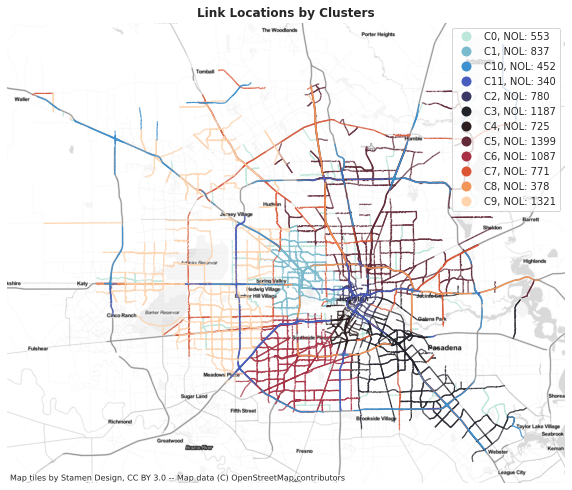

In [18]:
# nc = 12
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10, 10))
    shp.plot(column = 'label_text',cmap = "icefire", ax = ax, legend=True, linewidth=1.2)
    ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
    ax.axis('off')
    plt.title('Link Locations by Clusters', weight='bold')
plt.savefig('ClusterLocation.png', dpi = 1000, bbox_inches = 'tight')

<ipython-input-20-1e81a6ab9314>:6: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)


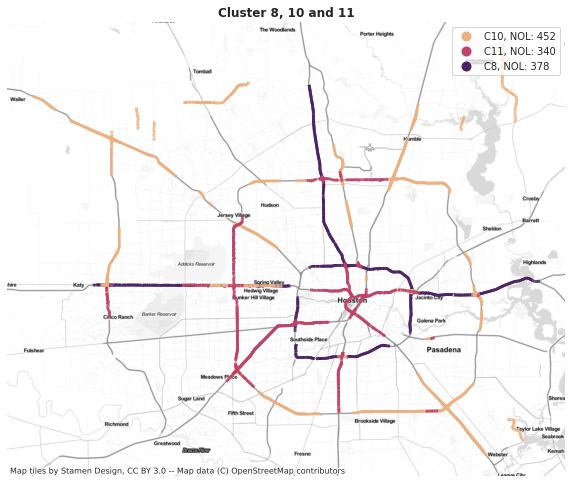

In [20]:
# nc = 12
cong_links = shp[shp.label.isin([8,10,11])]
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10, 10))
    cong_links.plot(column = 'label_text',cmap = "flare", ax = ax, legend=True, linewidth=2.8)
    ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
    ax.axis('off')
    plt.title('Cluster 8, 10 and 11', weight='bold')
plt.savefig('ClusterLocation.png', dpi = 1000, bbox_inches = 'tight')

In [ ]:
# nc = 12
cong_links = shp[shp.FUNCLASS.isin([3,4,5])]
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10, 10))
    cong_links.plot(column = 'label_text',cmap = "Paired", ax = ax, legend=True, linewidth=2.8)
    ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
    ax.axis('off')
    plt.title('Functional Class 3, 4 and 5', weight='bold')
plt.savefig('ClusterLocation.png', dpi = 1000, bbox_inches = 'tight')

<ipython-input-23-d9fd0ce7810a>:6: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)


In [ ]:
# # nc = 12
# # tmc['label'] = tmc['label'].astype(str)
# xmin = np.min(tmc['lon_x']); xmax = np.max(tmc['lon_x']); 
# ymin = np.min(tmc['lat_x']); ymax = np.max(tmc['lat_x']); 
# with sns.axes_style("whitegrid"):
#     fig = plt.figure(figsize=(10, 7))
#     plat = sns.color_palette("Paired",nc) # sns.color_palette("Paired")
#     g= sns.scatterplot(data=tmc, x="lon_x", y="lat_x", hue="label", palette=plat, s = 8)
#     plt.ylim(ymin,ymax); plt.xlim(xmin,xmax)
#     plt.xticks(fontsize=10);plt.yticks(fontsize=10)
#     plt.xlabel('Longitude');plt.ylabel('Latitude')
#     g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     legend = g.get_legend()
#     legend.set_title("Cluster ID & Num of Links")
#     leg_label=("C"+str(i)+', NOL: '+str(cluster_summary.loc[i,'TMC']) for i in np.unique(tmc['label']))
#     for t, l in zip(legend.texts,leg_label):
#         t.set_text(l)
#     plt.title('Link Locations by Clusters',weight='bold')
# # plt.savefig('ClusterLocation.png', dpi = 1000, bbox_inches = 'tight')

In [ ]:
# cls1 = mapping[mapping.FUNCLASS.isin([1,2])].TMC
# cls1 = tmc[tmc.TMC.isin(cls1)]
# # cls1 = cls1[cls1.label == 2]
# with sns.axes_style("whitegrid"):
#     fig = plt.figure(figsize=(10, 7))
#     plat = sns.color_palette("Paired",len(np.unique(cls1.label))) # sns.color_palette("Paired")
#     g = sns.scatterplot(data=cls1, x="lon_x", y="lat_x", hue="label", palette=plat, s = 10)
#     plt.ylim(ymin,ymax); plt.xlim(xmin,xmax)
#     plt.xticks(fontsize=10);plt.yticks(fontsize=10)
#     plt.xlabel('Longitude');plt.ylabel('Latitude')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     legend = g.get_legend()
#     legend.set_title("Cluster ID & Num of Links")
#     leg_label=("C"+str(i)+', NOL: '+ str(cluster_summary.loc[i,'TMC']) for i in np.unique(cls1.label).astype(int))
#     for t, l in zip(legend.texts,leg_label):
#         t.set_text(l)
#     plt.title('Link Locations by Clusters',weight='bold')

In [4]:
dt_sub_month = pd.read_pickle('data/inrix_AugSep2019.pkl')
dt_sub_month['TMC_combine'] = dt_sub_month['TMC']
dt_sub_month['TMC_combine'] = dt_sub_month['TMC_combine'].str.replace('+','P')
dt_sub_month['TMC_combine'] = dt_sub_month['TMC_combine'].str.replace('-','N')
# print(len(np.unique(dt_sub_month.TMC)))
# dt_sub_month = dt_sub_month[(dt_sub_month.TMC_combine.isin(HS_TMC))]
print(len(np.unique(dt_sub_month.TMC_combine)))

8271


In [ ]:
tmc['label'] = tmc['label'].astype(int)
# for INRXI data need
tmc=tmc.rename(columns = {'TMC':'TMC_combine'})
plot_cluster = pd.merge(dt_sub_month, tmc, how='left',on='TMC_combine')
# plot_cluster.to_csv('class.csv')
plot_cluster.head()

In [17]:
len(np.unique(plot_cluster.TMC))

13073

In [18]:
len(np.unique(plot_cluster.dropna().TMC))

9830

In [ ]:
plot_cluster = plot_cluster.dropna()
plot_cluster = plot_cluster[plot_cluster!=9999]
plot_cluster.head()

In [ ]:
plot_cluster[plot_cluster.TMC == "112P04199"].head()

In [28]:
plot_cluster = plot_cluster.groupby(['TMC','timeID']).mean().reset_index()
plot_cluster_resample = plot_cluster.drop(columns=['TMC']).groupby(np.arange(len(plot_cluster)) // 3).mean()
plot_cluster_resample['TMC'] = np.repeat(np.unique(plot_cluster['TMC']), len(plot_cluster) / 3 / len(np.unique(plot_cluster['TMC'])))

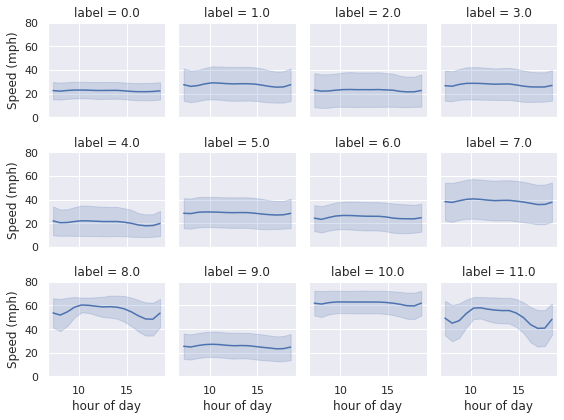

In [30]:
plot_cluster_resample['hour of day'] = plot_cluster_resample['timeID']/4
plot_cluster_resample = plot_cluster_resample.rename(columns={'MEAN': 'Speed (mph)'})
plot_cluster_resample.head()
# Plot the speed for different labels
sns.set_theme(style="darkgrid")
g = sns.FacetGrid(plot_cluster_resample, col="label", col_wrap=4, height=2, ylim=(0, 80))
g.map(sns.lineplot, "hour of day", "Speed (mph)", ci="sd")
plt.savefig('sd_SPD.png', dpi = 1000, bbox_inches = 'tight')

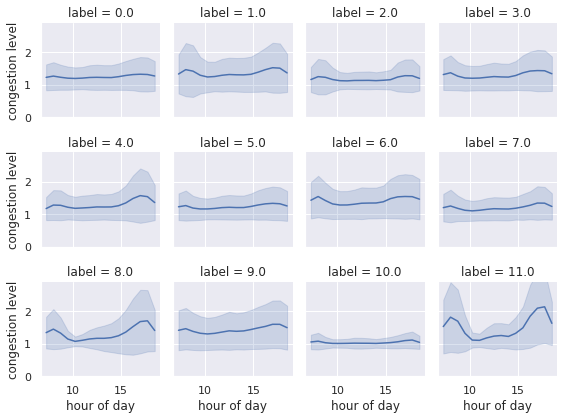

In [33]:
plot_cluster_resample = plot_cluster_resample.rename(columns={'congestion': 'congestion level'})
# Plot the songesion for different labels
sns.set_theme(style="darkgrid")
g = sns.FacetGrid(plot_cluster_resample, col="label", col_wrap=4, height=2, ylim=(0, 2.9))
g.map(sns.lineplot, "hour of day", "congestion level", ci="sd")
plt.savefig('sd_SPD.png', dpi = 1000, bbox_inches = 'tight')